In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
from joblib import load
from datetime import datetime, timezone
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')

In [3]:
model_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP'
preds_2023 = pd.read_csv(os.path.join(model_dir, 'YDC.P.preds.holdout.csv'))
scaler = load(os.path.join(model_dir, 'YDC.P.scaler.joblib'))

In [4]:
preds_2023['residual'] = preds_2023['magnitude'] - preds_2023['predicted_magnitude']

In [5]:
stat = "YDC"
proc = GatherFeatureDatasets(is_p=True)
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        test_df=all_test_df,
                                                                                        holdout_df=all_holdout_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)


In [6]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')

In [7]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
feature_inds = np.where(np.isin(feature_names, selected_features))[0]

In [8]:
train_means = station_feature_dict['X_train'][:, feature_inds].mean(axis=0)
holdout_means = station_feature_dict['X_holdout'][:, feature_inds].mean(axis=0)

In [9]:
train_means

array([-5.21530976, -3.9622945 , -2.02583686, -7.03751666,  8.10566598,
        3.07924129, 77.88072509])

In [10]:
holdout_means

array([-6.63620651, -5.84407495, -4.65750078, -7.29997342,  9.7837931 ,
        2.79951271, 77.61014236])

In [11]:
X_train = station_feature_dict['X_train']
X_holdout = station_feature_dict['X_holdout']

In [12]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [14]:
def plot_features(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    subpanel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
    sp_ind = 0
    good_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) > 0.5].Evid))
    print(bad_ind)
    cmap = matplotlib.colormaps["viridis"]
    norm = plt.Normalize(bad_ind[0].min(), bad_ind[0].max())
    edge_colors = cmap(norm(bad_ind[0]))

    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        s1 = ax.scatter(y_train, X_train[:, find], s=20, alpha=0.1, color='#737373', label='Train')
        s2 = ax.scatter(y_test[good_ind], X_test[good_ind, find], s=20, facecolors='none', edgecolor='k',
                   label='Test B')
        s3 = ax.scatter(y_test[bad_ind], 
                        X_test[bad_ind, find], 
                        s=20, 
                        #c=bad_ind[0],
                        #cmap='viridis',
                        facecolors='none', 
                        edgecolor=edge_colors, #'#fc9272', 
                        label='Test B - large resid.')
        if i == 0:
            legend_items = [s1, s2, s3]
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        ax.set_xticks(np.arange(0, 5))
        if i < 4:
            ax.set_xticklabels([])

        ax.text(0, 1.04, subpanel_labels[sp_ind], 
        transform=ax.transAxes,)
        sp_ind += 1
        i += 1

    axes[3].legend(legend_items, 
                   ['Train', 'Test B', 'Test B,\n|resid.| > 0.5'], 
                   loc='center',
                   handletextpad=0.2, borderpad=0.2, handlelength=1.0,
                   labelspacing=1.0)

    fig.supxlabel('$M_{L,YP21}$')
    fig.supylabel("Feature Value")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28]),)


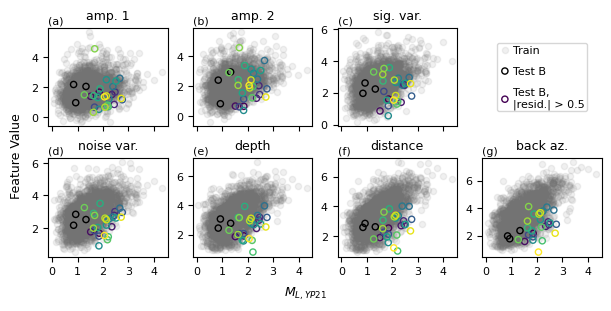

In [15]:
plot_features(X_train, station_meta_dict['y_train'], 
              X_holdout, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds],)
              #savefigname='../figures/examineFeatureDistsYDC.png')

(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28]),)


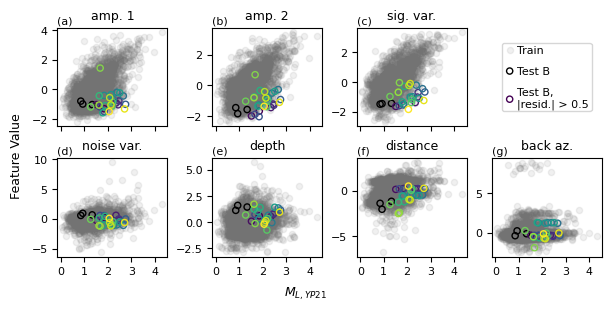

In [16]:
X_train_s = scaler.transform(X_train[:, feature_inds])
X_holdout_s = scaler.transform(X_holdout[:, feature_inds])
plot_features(X_train_s, station_meta_dict['y_train'], 
              X_holdout_s, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds],)
              #savefigname='../figures/examineFeatureDistsYDCScaled.png')

# Look for any systematic changes in amplitude related feature values at YDC

Given that there are very few P arrivals in the catalog at YDC in 2023, I think the story is probably that the analysts started to infrequently use the YDC station for making picks because it is only a one component station and there were likely more bb stations added nearby. I'd guess that they only use YDC for fairly low-quality events - which could be why there are generally lower amplitude/variance measurements in 2023 (i.e. the picks are very low SNR). Check with mark to see if that seems reasonable. 

In [17]:
cat = pd.read_csv("../data/catalogs/yellowstone.events.2024.csv")
cat.head()

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
0,60000005,44.743333,-111.067500,5.48,1.349112e+09,-0.20,d,F,2012-10-01 17:26:54.360001+00:00
1,60000010,44.438167,-111.032000,6.05,1.349101e+09,0.35,d,F,2012-10-01 14:24:40.459999+00:00
2,60000050,44.276000,-110.645667,2.18,1.350621e+09,1.15,d,F,2012-10-19 04:29:58.239998+00:00
3,60000060,44.346167,-110.327333,9.44,1.350808e+09,1.34,d,F,2012-10-21 08:32:33.660000+00:00
4,60000065,44.395000,-111.021833,4.71,1.350274e+09,0.82,d,F,2012-10-15 04:14:30.209999+00:00


In [18]:
train_cat = cat[cat["evid"].isin(station_meta_dict["evids_train"])]
holdout_cat = cat[cat["evid"].isin(station_meta_dict["evids_holdout"])]
assert train_cat.shape[0] == station_meta_dict["evids_train"].shape[0]
assert np.array_equal(train_cat.evid.values, station_meta_dict["evids_train"])
assert holdout_cat.shape[0] == station_meta_dict["evids_holdout"].shape[0]
assert np.array_equal(holdout_cat.evid.values, station_meta_dict["evids_holdout"])

In [19]:
train_cat.head()

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
49,60000622,44.764500,-111.088000,7.69,1.349570e+09,0.83,l,F,2012-10-07 00:32:04.740000+00:00
117,60001352,44.389333,-111.035833,14.30,1.350269e+09,2.06,l,F,2012-10-15 02:44:35.520000+00:00
121,60001367,44.406333,-111.053833,10.32,1.350270e+09,2.03,l,F,2012-10-15 02:51:45.939999+00:00
125,60001387,44.399000,-111.044500,15.82,1.350270e+09,2.19,l,F,2012-10-15 02:56:34.779999+00:00
127,60001397,44.402167,-111.054000,14.47,1.350270e+09,2.25,l,F,2012-10-15 02:59:33.559998+00:00


In [20]:
holdout_cat.head()

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
19730,60530187,44.750833,-111.112333,10.94,1.674524e+09,0.79,l,F,2023-01-24 01:29:17.529999+00:00
19768,60530391,44.798833,-110.960000,9.61,1.675788e+09,1.71,l,F,2023-02-07 16:42:05.120000+00:00
19772,60530416,44.789500,-110.968833,8.30,1.675804e+09,1.47,l,F,2023-02-07 21:11:27.260000+00:00
19777,60530456,44.793000,-110.965333,9.45,1.675824e+09,2.46,l,F,2023-02-08 02:32:20.320000+00:00
19781,60530466,44.797333,-110.967000,9.96,1.675826e+09,2.47,l,F,2023-02-08 03:09:47.919998+00:00


In [39]:
all_X = np.concatenate([X_train[:, :], X_holdout[:, :]])
all_X_s = np.concatenate([X_train_s[:, :], X_holdout_s[:, :]])
all_y = np.concatenate([station_meta_dict['y_train'], station_meta_dict['y_holdout']])
all_ot = np.concatenate([train_cat["origin_time"].values,
                holdout_cat["origin_time"].values])
print(all_X.shape, all_y.shape, all_ot.shape)

(2957, 45) (2957,) (2957,)


In [53]:
feature_name = "signal_variance"
ind = np.where(feature_names == "signal_variance")[0][0]
scaled_ind = np.where(feature_names[feature_inds] == feature_name)[0][0]

In [73]:
starttime = datetime(2013, 1, 1, tzinfo=timezone.utc).timestamp()
summary = []
for i, year in enumerate(range(2014, 2025)):
    endtime = datetime(year, 1, 1, tzinfo=timezone.utc).timestamp()
    print(starttime, endtime)
    year_inds = np.where((all_ot >= starttime) & (all_ot < endtime))[0]
    year_filt_X = all_X_s[year_inds, scaled_ind:scaled_ind+1]
    year_filt_y = all_y[year_inds]
    year_filt_ot = all_ot[year_inds]
    startmag = 0.0
    year_results = []
    for endmag in np.arange(0.5, 5.0, 0.5):
        mag_inds = np.where((year_filt_y >= startmag) & (year_filt_y < endmag))[0]
        if len(mag_inds) < 2:
            startmag=endmag
            q1, median, q3 = np.nan, np.nan, np.nan  
        else:  
            pos = (endmag+startmag)/2
            print(startmag, endmag, pos)   
            q1, median, q3 = np.quantile(year_filt_X[mag_inds, :], [0.25, 0.5, 0.75])
        summary.append([starttime, endtime, startmag, endmag, q1, median, q3, len(mag_inds)])
        startmag=endmag
    starttime = endtime
year_mag_df = pd.DataFrame(summary, columns=["start_time", "end_time", "start_mag", "end_mag", "q1", "median", "q3", "N"])

1356998400.0 1388534400.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
3.0 3.5 3.25
1388534400.0 1420070400.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
3.0 3.5 3.25
1420070400.0 1451606400.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
1451606400.0 1483228800.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
1483228800.0 1514764800.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
3.0 3.5 3.25
1514764800.0 1546300800.0
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
3.0 3.5 3.25
1546300800.0 1577836800.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
1577836800.0 1609459200.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
1609459200.0 1640995200.0
0.0 0.5 0.25
0.5 1.0 0.75
1.0 1.5 1.25
1.5 2.0 1.75
2.0 2.5 2.25
2.5 3.0 2.75
1640995200.0 1672531200.0
0.0 0.5 0.25
0.5 1.0 0.75

In [74]:
year_mag_df.tail(10)

,start_time,end_time,start_mag,end_mag,q1,median,q3,N
89,1.640995e+09,1.672531e+09,4.5,4.5,NaN,NaN,NaN,0
90,1.672531e+09,1.704067e+09,0.5,0.5,NaN,NaN,NaN,0
91,1.672531e+09,1.704067e+09,0.5,1.0,-1.481405,-1.472327,-1.463250,2
92,1.672531e+09,1.704067e+09,1.0,1.5,-1.321498,-1.207343,-1.093187,2
93,1.672531e+09,1.704067e+09,1.5,2.0,-1.532210,-1.419888,-0.689356,10
94,1.672531e+09,1.704067e+09,2.0,2.5,-1.275447,-1.010730,-0.471578,11
95,1.672531e+09,1.704067e+09,2.5,3.0,-1.132086,-0.882897,-0.616088,4
96,1.672531e+09,1.704067e+09,3.5,3.5,NaN,NaN,NaN,0
97,1.672531e+09,1.704067e+09,4.0,4.0,NaN,NaN,NaN,0
98,1.672531e+09,1.704067e+09,4.5,4.5,NaN,NaN,NaN,0


Text(0, 0.5, 'Number of examples (training ex. only before 2023)')

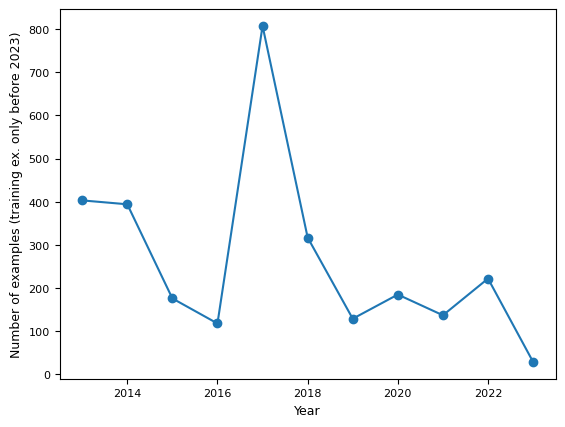

In [91]:
year_cnts = year_mag_df.groupby("start_time")["N"].sum().reset_index()
plt.plot(year_cnts.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                   tz=timezone.utc).year, axis=1), 
         year_cnts["N"], marker="o")
plt.xlabel("Year")
plt.ylabel("Number of examples (training ex. only before 2023)")

Text(0, 0.5, 'signal_variance')

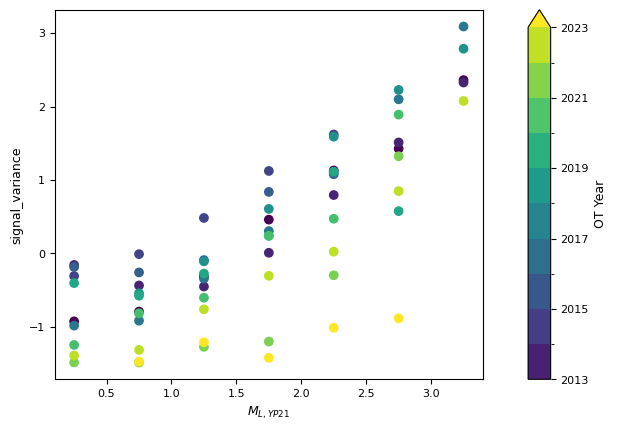

In [76]:
# Scaled features by magnitude bin
cmap = matplotlib.colormaps["viridis"]
bounds = np.arange(2013, 2024)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')
fig, ax = plt.subplots(1, 2,
                       width_ratios=[0.95, 0.05])
ax[0].scatter((year_mag_df["end_mag"]+year_mag_df["start_mag"])/2,
            year_mag_df["median"],
            c=year_mag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                tz=timezone.utc).year, axis=1),
            cmap=cmap)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1], extend="max", label="OT Year"
             )

ax[0].set_xlabel("$M_{L,YP21}$")
ax[0].set_ylabel(feature_name)

0.25
0.75
1.25
1.75
2.25
2.75
3.25
4.0
4.5
3.5


Text(0, 0.5, 'signal_variance')

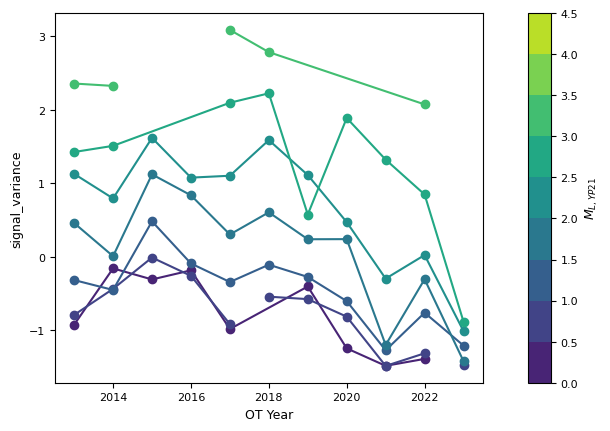

In [78]:
# Scaled feature as a function of time
cmap = matplotlib.colormaps["viridis"]
bounds = np.arange(0.0, 5.0, 0.5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')
fig, ax = plt.subplots(1, 2,
                       width_ratios=[0.95, 0.05])
for startmag in year_mag_df["start_mag"].unique():     
    startmag_df = year_mag_df[year_mag_df["start_mag"] == startmag]  
    cmap_input = (startmag_df.iloc[0]["end_mag"]+startmag_df.iloc[0]["start_mag"])/2
    print(cmap_input)      
    ax[0].plot(startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                    tz=timezone.utc).year, axis=1),
                startmag_df["median"],
                c=cmap(norm(cmap_input)),
                marker='o')

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1], extend='neither', label="$M_{L,YP21}$"
             )

ax[0].set_xlabel("OT Year")
ax[0].set_ylabel(feature_name)

0.5 2.0
1.0 2.0
1.5 10.0
2.0 11.0
2.5 4.0


Text(0, 0.5, 'signal_variance')

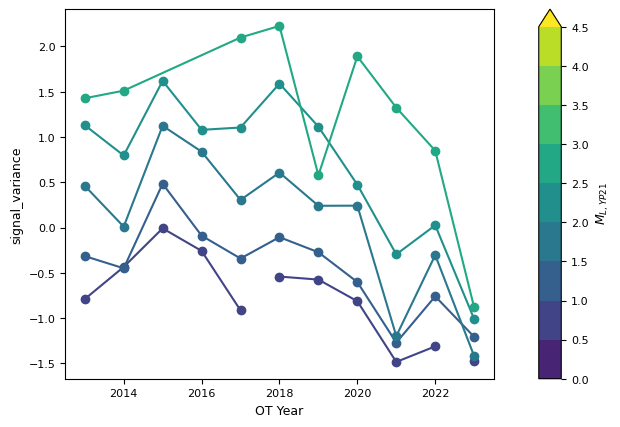

In [89]:
# Scaled feature as a function of time
# Only plot mag bins that have examples in 2023
cmap = matplotlib.colormaps["viridis"]
bounds = np.arange(0.0, 5.0, 0.5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')
fig, ax = plt.subplots(1, 2,
                       width_ratios=[0.95, 0.05])
for startmag in year_mag_df[(year_mag_df["start_time"] == 1672531200.0) & 
                (~np.isnan(year_mag_df["median"]))]["start_mag"].values:     
    startmag_df = year_mag_df[year_mag_df["start_mag"] == startmag]  
    cmap_input = (startmag_df.iloc[0]["end_mag"]+startmag_df.iloc[0]["start_mag"])/2
    print(startmag, startmag_df.iloc[-1]["N"])      
    ax[0].plot(startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                    tz=timezone.utc).year, axis=1),
                startmag_df["median"],
                c=cmap(norm(cmap_input)),
                marker='o')

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1], extend='max', label="$M_{L,YP21}$"
             )

ax[0].set_xlabel("OT Year")
ax[0].set_ylabel(feature_name)

Text(0, 0.5, 'signal_variance')

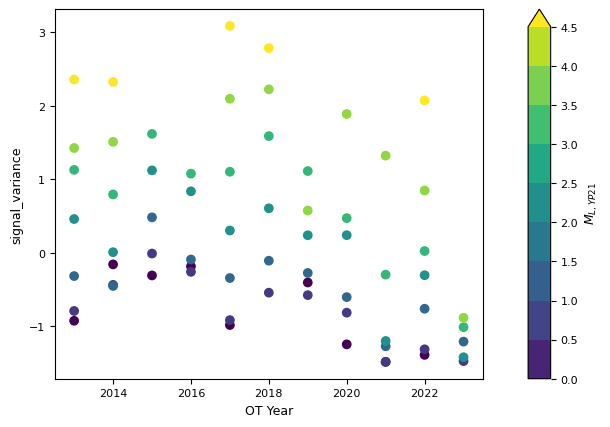

In [77]:
cmap = matplotlib.colormaps["viridis"]
bounds = np.arange(0.0, 5.0, 0.5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')
fig, ax = plt.subplots(1, 2,
                       width_ratios=[0.95, 0.05])                       
ax[0].scatter(year_mag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                tz=timezone.utc).year, axis=1),
            year_mag_df["median"],
            c=(year_mag_df["end_mag"]+year_mag_df["start_mag"])/2,
            cmap=cmap)

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1], extend='max', label="$M_{L,YP21}$"
             )

ax[0].set_xlabel("OT Year")
ax[0].set_ylabel(feature_name)

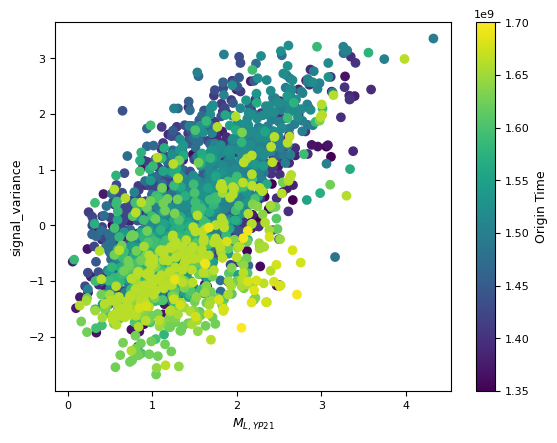

In [54]:
# TODO make plot to see if there is a systematic change in amplitude values as a function of time and magnitude
plt.scatter(all_y,
            all_X_s[:, scaled_ind],
            c=all_ot,
            cmap="viridis"
            )

plt.xlabel("$M_{L,YP21}$")
plt.ylabel(feature_name)
plt.colorbar(label="Origin Time")

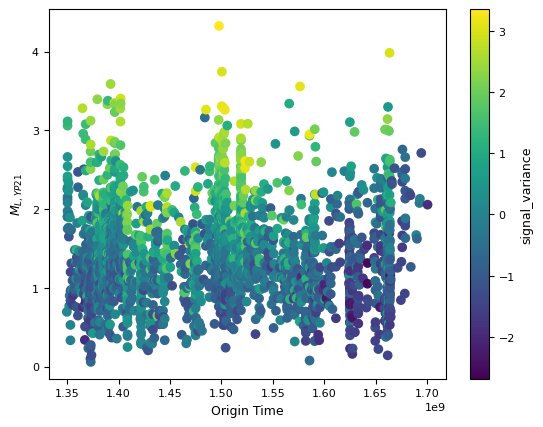

In [56]:
#cmap = matplotlib.colormaps[name]
plt.scatter(all_ot, 
            all_y,
            c=all_X_s[:, scaled_ind],
            cmap="viridis"
            )
plt.xlabel("Origin Time")
plt.ylabel("$M_{L,YP21}$")
plt.colorbar(label=feature_name)

In [17]:
def plot_features_single_holdout_ex(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None,
                  ylim=[0, 6],
                  sharey=False):
    fig, axes = plt.subplots(2, 4, 
                            constrained_layout=True, figsize=(6, 3), sharey=sharey)
    axes = axes.flatten()
    i = 0
    subpanel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
    sp_ind = 0
    good_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) > 0.5].Evid))

    for find in feature_inds:
        ax = axes[i]
        if ylim is not None:
            ax.set_ylim(ylim)
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        s1 = ax.scatter(y_train, X_train[:, find], s=20, alpha=0.1, color='#737373', label='Train')
        if len(good_ind[0]) > 0:
            s2 = ax.scatter(y_test[good_ind], X_test[good_ind, find], s=20, facecolors='none', edgecolor='k',
                    label='Test B')
        if len(bad_ind[0]) > 0:
            s3 = ax.scatter(y_test[bad_ind], 
                X_test[bad_ind, find], 
                s=20, 
                facecolors='none', 
                edgecolor='#fc9272', 
                label='Test B - large resid.')

        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        ax.set_xticks(np.arange(0, 5))
        if i < 4:
            ax.set_xticklabels([])

        ax.text(0, 1.04, subpanel_labels[sp_ind], 
        transform=ax.transAxes,)
        sp_ind += 1
        i += 1

    fig.supxlabel('$M_{L,YP21}$')
    fig.supylabel("Feature Value")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

In [ ]:
for i in range(X_holdout.shape[0]):
    plot_features_single_holdout_ex(X_train, station_meta_dict['y_train'], 
                X_holdout[i:i+1, :], station_meta_dict['y_holdout'][i:i+1], 
                station_meta_dict['evids_holdout'][i:i+1], preds_2023,
                np.arange(0, 7), feature_plot_names[feature_inds],sharey=True)

In [ ]:
for i in range(X_holdout.shape[0]):
    plot_features_single_holdout_ex(X_train_s, station_meta_dict['y_train'], 
                X_holdout_s[i:i+1, :], station_meta_dict['y_holdout'][i:i+1], 
                station_meta_dict['evids_holdout'][i:i+1], preds_2023,
                np.arange(0, 7), feature_plot_names[feature_inds],ylim=None)

In [19]:
def plot_hist(X_train, 
                  X_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        ax.hist(X_train[:, find], color='#737373')
        good_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual <= 0.5].Evid))
        bad_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual > 0.5].Evid))
        ax.hist(X_test[bad_ind, find].flatten(), color='#fc9272')
        ax.hist(X_test[good_ind, find].flatten(), color='k')
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        if i < 4:
            ax.set_xticklabels([])
        i += 1

    fig.supxlabel('Feature Value')
    fig.supylabel("Counts")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

In [ ]:
plot_hist(X_train,  
              X_holdout, 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds])

In [21]:
def plot_hist_single_heldout_ex(X_train, 
                  y_train,
                  X_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    good_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual > 0.5].Evid))
    for find in feature_inds:
        ax = axes[i]
        ax.hist(X_train[:, find], color='#737373')
        if len(bad_ind[0]) > 0:
            ax.axvline(X_test[bad_ind, find].flatten(), color='#fc9272')
        else:
            ax.axvline(X_test[good_ind, find].flatten(), color='k')
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        # if i < 4:
        #     ax.set_xticklabels([])
        i += 1

    ax = axes[i]
    ax.hist(y_train, color='#737373')
    if len(bad_ind[0]) > 0:
        ax.axvline(test_preds.iloc[bad_ind[0][0]].magnitude, color='#fc9272')
    else:
        ax.axvline(test_preds.iloc[good_ind[0][0]].magnitude, color='k')
    ax.set_title("$M_{L,YP21}$")    
    fig.supxlabel('Feature Value')
    fig.supylabel("Counts")

In [ ]:
for i in range(X_holdout.shape[0]):
    plot_hist_single_heldout_ex(X_train,  
                                station_meta_dict['y_train'],
                                X_holdout[i:i+1, :], 
                                station_meta_dict['evids_holdout'][i:i+1], preds_2023,
                                np.arange(0, 7), feature_plot_names[feature_inds])